# Example: Forward Algorithm

## Contents
* [Acknowledgements](#ackw)
* [Overview](#overview) 
* [Forward algorithm](#ekf)
    * [Example](#test_case_4_1_2)
    * [Log probabilities](#test_case_4_2)
* [References](#refs)

## <a name="ackw"></a> Acknowledgements

## <a name="overview"></a> Overview

This notebook discusses the so-called <a href="https://en.wikipedia.org/wiki/Forward_algorithm">forward algorithm</a> for solving the evaluation problem i.e. solving for $P(O| \lambda)$ when dealing with Hidden Markov models. The motivation behind the forward algorithm is nicely presented in the following video 

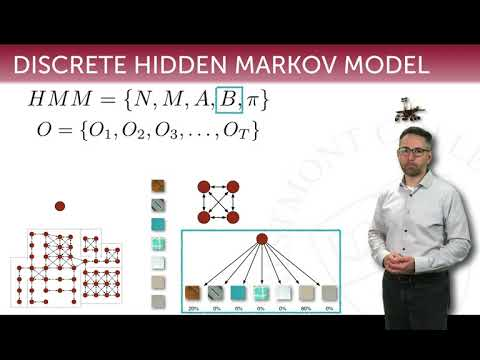

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('EbxLWGw2zJ4', width=800, height=300)

The following video nicely explains both the forward and backward algorithms.

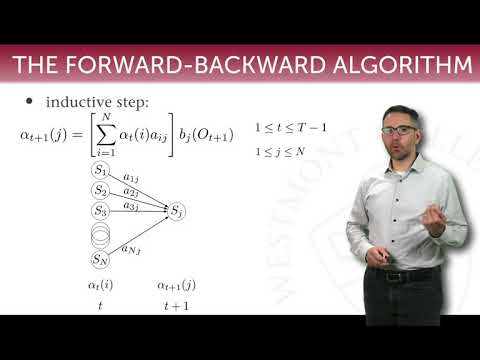

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('gYma8Gw38Os', width=800, height=300)

## <a name="ekf"></a> The forward algorithm

Our goal here is to evaluate the following probability $P(O|\lambda)$ that is the probability of the observation sequence under model $\lambda$. In theory, this can be calculated by using 

$$P(O|\lambda) = \sum_{Q}P(O, Q|\lambda)$$

where 

$$P(O, Q|\lambda) = P(q_1)\Pi_{t=2}^{T}P(q_t|q_{t-1})\Pi_{t=1}^{T}P(O_t|q_{t})$$

Despite this, you should note that there are $N^T$ possible $Q$s assuming that all probabilities are nonzero [1]. Thus, the marginalization step above is  rather, or can be, computationally expensive. We need another way to calculate $P(O|\lambda)$. 

In order to compute the probability $P(O|\lambda)$ we need to know the joint probability $P(O, Q|\lambda)$. The forward algorithm allows us to compute the latter without using the marginalization step. It does so by using recursion. We will divide the observation sequence into two parts; the first  part will be $[1,t]$, the second is $[t+1, T]$ [1].  We further define the forward variable $\alpha_t(i)$. This will denote the probability of observing the partial sequence  $\{O_1,\cdots,O_t\}$ unitl time $t$ and being in $S_i$ at time $t$ given $\lambda$:

$$\alpha_t(i) = P(O_1,\cdots,O_t, q_t = S_i | \lambda)$$

This can be calculated recursively: 

- **Initialize** 

$$\alpha_t(i) = \pi_ib_i(O_1)$$

- **Recurse**

$$\alpha_{t+1}(j) = P(O_1,\cdots,O_{t+1}, q_{t+1} = S_j | \lambda)$$

which can be written as, see [1],

$$\alpha_{t+1}(j) = [\sum_{i}^{N}\alpha_t(i)a_{i,j}]b_j(O_{t+1})$$

Now $\alpha_t(i)$ explains the first $t$ observations and ends in state $S_i$. We multiply with the transition probability $a_{ij}$ in order to move to state $S_j$. since the are $N$ possible previous states we have to sum over all of them. Finally, we weight the result with $b_j(O_{t+1})$ which is the probability of observing $O_{t+1}$ at state $S_j$ at time $t+1$. Once we know the forward variables, i.e. $\alpha$, it is easy  to calculate $P(O|\lambda)$:

$$P(O|\lambda) = \sum_{i}^{N}\alpha_{T}(i)$$

where $\alpha_{T}(i)$ is the probability of generating the full observation sequence and ending up in state $S_i$. We need to sum up over all the possible final states.

The $\alpha_{t}(i)$ can be represented as a matrix of size $T \times N$. Where $T$ is the size of the observation sequence and $N$ the number of states. Let's see an example.

###  <a name="test_case_4_2"></a> Log probabilities

The forward variable, as well as the backward variable used in the <a href="https://en.wikipedia.org/wiki/Forward%E2%80%93backward_algorithm">backward algorithm</a> are calculated as products of probabilities. When we have long sequences this mat result in underflow [1]. In order to avoid this, we normalize $\alpha_t(i)$ by multiplying it with

$$c_t = \frac{1}{\sum_{j}\alpha_t(j)}$$

After this normalization, $P(O| \lambda)$ is given by 

$$P(O| \lambda) = \frac{1}{\Pi_t c_t}$$

or

 $$logP(O| \lambda) = - \sum_t log c_t$$

### <a name="test_case_4_1_2"></a> Example

Assume a system with three states $S=\{S_1, S_2, S_3 \}$. Futher, assume that the observation sequence consists of elements from the following set $V=\{a, b,c\}$. Also let's assume the following HMM:

$$\boldsymbol{\pi}=\begin{bmatrix}0.7 & 0.15 & 0.15 \end{bmatrix}$$

$$\mathbf{A}=\begin{bmatrix}0.5 & 0.25 & 0.25 \\ 0.1 & 0.8 & 0.1\\ 0.3 & 0.15 & 0.6\end{bmatrix}$$

$$\mathbf{B}=\begin{bmatrix} 0.16 & 0.26 & 0.58 \\ 0.25 & 0.28 & 0.47\\ 0.2 & 0.1 & 0.7\end{bmatrix}$$

We want to calculate the probability $P(O|\lambda)$ where $O=\{a, b, a, c, b, a\}$. We will use the forward algorithm for this. We will first do the computation using pencil and paper and then write a small Python script for us. We create the matrix $\alpha$:

$$ \alpha =\begin{bmatrix}0 & 0 & 0 \\ 0 & 0 & 0 \\ 0 & 0 & 0 \\ 0 & 0 & 0 \\ 0 & 0 & 0 \\ 0 & 0 & 0\end{bmatrix}$$

The first step is the initialization of the matrix. We take the first observation in the sequence $O$ which ```'a'```. This has to be mapped to an index. Assume that we have available such a mapping:

$$\{a:0, b:1, c:2 \}$$

Further assume that we use zero-based counting. We have 

$$\alpha_{0,0} = \pi_0\mathbf{B}_{0, 0} = 0.7  0.16 = 0.112$$

$$\alpha_{0,1} = \pi_1\mathbf{B}_{1, 0} = 0.15  0.25 = 0.0375 $$

$$\alpha_{0,2} = \pi_2\mathbf{B}_{2, 0} = 0.15  0.2 = 0.03$$

we now proceed to the calculation of the probabilities of the next symbols. The symbols ```'b'```, which is the next symbol in $O$ has index ```1```. Its  probabilities are

$$ \alpha_{1,0} = \mathbf{B}_{0,1}(\alpha_{0,0}\mathbf{A}_{0,0} + \alpha_{0,1}\mathbf{A}_{1,0} + \alpha_{0,2}\mathbf{A}_{2,0}) $$

Similarly for $\alpha_{1,1}$ and $\alpha_{1,2}$

$$ \alpha_{1,1} = \mathbf{B}_{1,1}(\alpha_{0,0}\mathbf{A}_{0,1} + \alpha_{0,1}\mathbf{A}_{1,1} + \alpha_{0,2}\mathbf{A}_{2,1}) $$

$$ \alpha_{1,2} = \mathbf{B}_{2,1}(\alpha_{0,0}\mathbf{A}_{0,2} + \alpha_{0,1}\mathbf{A}_{1,2} + \alpha_{0,2}\mathbf{A}_{2,2}) $$

After filling the matrix $\alpha$ we can calculate the probability $P(O| \lambda)$, This is given by the following sum:

$$P(O| \lambda) = \alpha_{5,0} + \alpha_{5,1} + \alpha_{5,2}$$

The following Java code does the calculations for us. We wrap the forward algorithm in the ```HMMHelpers.forward``` function. The signature of the function is shown below

```INDArray  forward(List<String> sequence, INDArray A,
                     INDArray B, INDArray pi, Map<String, Integer> obsToIdx);```

The ```obsToIdx``` parameter maps the observation in the sequence to a column in the given matrix ```B```. The rest of the parameters describe what we discussed above. Here is the full Java code

```
package examples.ml_examples.example10;

import org.nd4j.linalg.api.ndarray.INDArray;
import org.nd4j.linalg.factory.Nd4j;
import ml.models.HMMHelpers;

import java.util.ArrayList;
import java.util.HashMap;
import java.util.List;
import java.util.Map;

public class Example10 {

    public static void main(String[] args){

        // create the transition probability matrix
        int nRows = 3;
        int nColumns = 3;
        INDArray A = Nd4j.zeros(nRows, nColumns);

        A.putScalar(0,0, 0.5);
        A.putScalar(0,1, 0.25);
        A.putScalar(0,2, 0.25);
        A.putScalar(1,0, 0.1);
        A.putScalar(1,1, 0.8);
        A.putScalar(1,2, 0.1);
        A.putScalar(2,0, 0.3);
        A.putScalar(2,1, 0.15);
        A.putScalar(2,2, 0.6);

        // create the emission probability matrix
        INDArray B = Nd4j.zeros(3, 3);

        B.putScalar(0,0, 0.16);
        B.putScalar(0,1, 0.26);
        B.putScalar(0,2, 0.58);
        B.putScalar(1,0, 0.25);
        B.putScalar(1,1, 0.28);
        B.putScalar(1,2, 0.47);
        B.putScalar(2,0, 0.2);
        B.putScalar(2,1, 0.1);
        B.putScalar(2,2, 0.7);

        // create the initialization vector
        INDArray pi = Nd4j.create(new double[]{0.7, 0.15, 0.15});

        // create a sequence of observations
        List<String> sequence = new ArrayList<String>();
        sequence.add("a");
        sequence.add("b");
        sequence.add("a");
        sequence.add("c");
        sequence.add("b");
        sequence.add("a");
        
        // map the sequnce observation to a column index
        Map<String, Integer> obsToIdx = new HashMap<>();
        obsToIdx.put("a", 0);
        obsToIdx.put("b", 1);
        obsToIdx.put("c", 2);

        // compute alpha
        INDArray alpha = HMMHelpers.forward(sequence, A, B, pi, obsToIdx);

        System.out.println("alpha matrix: ");
        System.out.println(alpha);

        // we can now calculate the probability
        double p = 0.0;
        for(int i=0; i<A.shape()[0]; ++i){
            p += alpha.getDouble(sequence.size()-1, i);
        }

        System.out.println("probability: " + p);
    }
}

```

Running the code above gives us

```
alpha matrix: 
[[    0.1120,    0.0375,    0.0300], 
 [    0.0179,    0.0175,    0.0050], 
 [    0.0019,    0.0048,    0.0018], 
 [    0.0012,    0.0022,    0.0015], 
 [    0.0003,    0.0006,    0.0001], 
 [ 4.2311e-5,    0.0002, 4.5118e-5]]
probability: 2.3811292339814827E-4

Process finished with exit code 0
```

## <a name="refs"></a> References


1. Ethem Alpaydin, ```Introduction To Machine Learning, Second Edition```, MIT Press.
2. <a href="https://en.wikipedia.org/wiki/Forward%E2%80%93backward_algorithm">Forward–backward algorithm</a>.
3. Lawrence R. Rabiner, ```A Tutorial on Hidden Markov Models and Selected Applications in Speech Recognition```.